In [58]:
#Se instalan librerias
! pip install transformers
! pip install pycaret
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

#Se especifica uso de GPU
device = torch.device("cuda")

#Directorio google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/proyectosIA/deteccionFakeNewsBERT

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/proyectosIA/deteccionFakeNewsBERT


Numero de registros en data: 44898


Text(0.5, 1.0, 'Distribucion del conjunto de datos falsos y verdaderos')

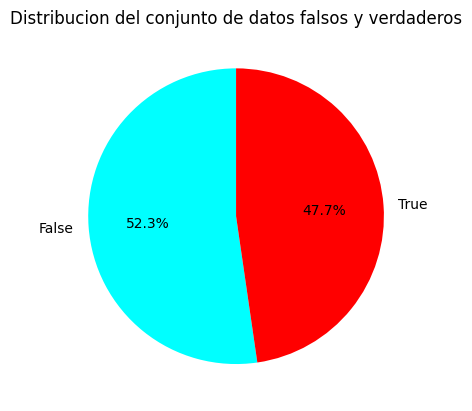

In [59]:
#Se carga el dataset
trueData = pd.read_csv('/content/drive/MyDrive/proyectosIA/deteccionFakeNewsBERT/news/True.csv')
falseData = pd.read_csv('/content/drive/MyDrive/proyectosIA/deteccionFakeNewsBERT/news/Fake.csv')

#Se generan labels para true/fake en una nueva target column en ambos datasets
trueData['Target'] = ['True']*len(trueData)
falseData['Target'] = ['False']*len(falseData)

#Se unen trueData y falseData con random mixing (sample) en un solo dataset 'data'
data = pd.concat([trueData, falseData]).sample(frac=1).reset_index(drop=True)

#Se cambia la columna Target de valores True/false por valores numericos 0/1 (falso = 1)
data['label'] = pd.get_dummies(data.Target)['False']

#Checar si la informacion tiene balance
print(f'Numero de registros en data: {data.shape[0]}')
labelSize = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(labelSize,colors=['cyan','red'],startangle=90,labels=['False','True'],autopct='%1.1f%%')
plt.title('Distribucion del conjunto de datos falsos y verdaderos')

In [60]:
#Se separa la data para entenamiento-validacion-testeo en 70:15:15

#split entrenamiento-temp
trainText, tempText, trainLabels, tempLabels = train_test_split(data['title'], data['label'],
                                                                random_state=2018, test_size=0.3,
                                                                stratify=data['Target'])
#split validacion-test
valText, testText, valLabels, testLabels = train_test_split(tempText, tempLabels,
                                                            random_state=2018,
                                                            test_size=0.5,
                                                            stratify=tempLabels)

Text(0, 0.5, 'numero de textos')

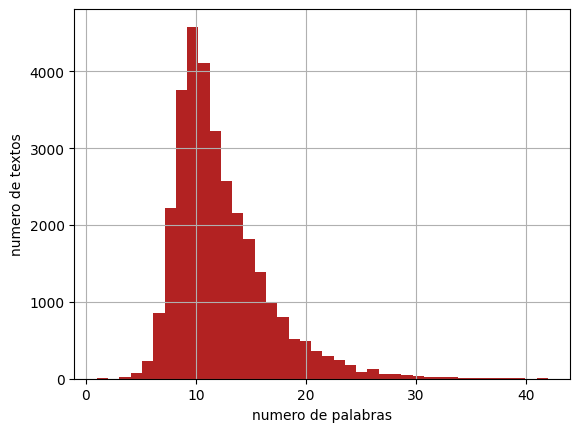

In [61]:
#Se carga BERT y tokenizer por la libreria Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

#Histograma del numero de palabras en el trainData 'title'
seq_len = [len(title.split()) for title in trainText]
pd.Series(seq_len).hist(bins = 40, color = 'firebrick')
plt.xlabel('numero de palabras')
plt.ylabel('numero de textos')

In [62]:
#La mayoria de los titulos se encuentran con una longitud de palabras menor a 20, por lo que
#se propone una longitud maxima de 20
MAXLENGTH = 16

#Se tokeniza y se codifican las secuencias en el set de entrenamiento
tokensTrain = tokenizer.batch_encode_plus(
    trainText.tolist(),
    max_length = MAXLENGTH,
    pad_to_max_length = True,
    truncation = True
)

#Se tokeniza y se codifican las secuencias en el set de validacion
tokensVal = tokenizer.batch_encode_plus(
    valText.tolist(),
    max_length = MAXLENGTH,
    pad_to_max_length = True,
    truncation = True
)

#Se tokeniza y se codifican las secuencias en el set de test
tokensTest = tokenizer.batch_encode_plus(
    testText.tolist(),
    max_length = MAXLENGTH,
    pad_to_max_length = True,
    truncation = True
)

#Se convierten las listas a tensores
trainSeq = torch.tensor(tokensTrain['input_ids']) #contiene las secuencias tokenizadas o IDs de tokens
trainMask = torch.tensor(tokensTrain['attention_mask']) #mascara para indicar tokens reales[1] y de relleno[0]
train_y = torch.tensor(trainLabels.tolist(), dtype=torch.long) #etiquetas para los datos de entrenamiento que se convierten a tensor desde una lista
valSeq = torch.tensor(tokensVal['input_ids'])
valMask = torch.tensor(tokensVal['attention_mask'])
val_y = torch.tensor(valLabels.tolist(), dtype=torch.long)
testSeq = torch.tensor(tokensTest['input_ids'])
testMask = torch.tensor(tokensTest['attention_mask'])
test_y = torch.tensor(testLabels.tolist(), dtype=torch.long)

#Definicion de la estructura de carga de datos
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32 #se especifica el tamaño del batch (numero de ejemplos antes de actualizar el modelo)
train_data = TensorDataset(trainSeq, trainMask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size) #dataloader para ser de entrenamiento

valData = TensorDataset(valSeq, valMask, val_y)
val_sampler = SequentialSampler(valData)
val_dataloader = DataLoader(valData, sampler = val_sampler, batch_size = batch_size) #dataloader para set de validacion



In [63]:
#Se congelan los parametros y se define la estructura BERT entrenable
for param in bert.parameters():
  param.requires_grad = False #falso significa que no se calcularan gradientes

In [64]:
#Se define la arquitectura del modelo
class BERT_Arch(nn.Module):
  def __init__(self, bert):
    super(BERT_Arch, self).__init__()
    self.bert = bert
    self.dropout = nn.Dropout(0.1) #capa de dropout
    self.relu = nn.ReLU() #funcion de activacion relu
    self.fc1 = nn.Linear(768,512) #capa 1 densa
    self.fc2 = nn.Linear(512,2) #capa 2 densa (capa de output)
    self.softmax = nn.LogSoftmax(dim=1) #funcion de activacion softmax
  def forward(self, sent_id, mask):
    cls_hs = self.bert(sent_id, attention_mask = mask)['pooler_output']
    #se pasan los inputs al modelo
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x) #capa de output
    x = self.softmax(x) #se aplica la activacion softmax
    return x
model = BERT_Arch(bert)
#se definen los hiperparametros (optimizador, pesos de las clases y de los epochs)
#se define el optimizador
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-5)
#se define la funcion de perdida
cross_entropy = nn.NLLLoss()
#numero de epochs de entrenamiento
epochs = 2

In [65]:
#Definiendo las funciones de entrenamiento y evaluacion
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                #iteracion sobre los batches
    if step % 50 == 0 and not step == 0:                        #actualizacion del proceso cada 50 batches
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  #se manda el batch al gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           #se limpia lo calculado previamente
    preds = model(sent_id, mask)                                #se obtienen las predicciones del modelo para el batch actual
    loss = cross_entropy(preds, labels)                         #se obtiene la perdida entre los valores actuales y los predecidos
    total_loss = total_loss + loss.item()                       #se añade a la perdida total
    loss.backward()                                             #se devuelve para calcular lo restante
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     #clipping de las gradientes (previene explosiones)
    optimizer.step()                                            #se actualizan los parametros
    preds=preds.detach().cpu().numpy()                          #se guardan las predicciones del modelo en el GPU

    avg_loss = total_loss/len(train_dataloader)

    return avg_loss

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss





 Epoch 1 / 2

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.001
Validation Loss: 0.695


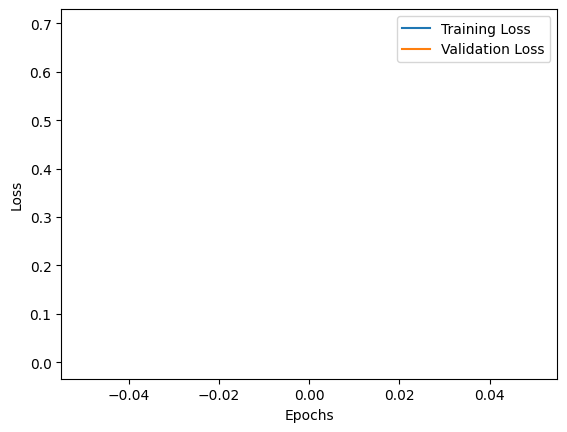


 Epoch 2 / 2

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.001
Validation Loss: 0.693


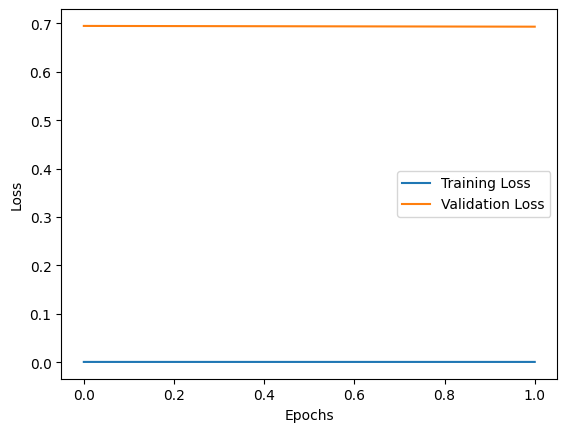

In [66]:
#Se entrena y se generan predicciones
best_valid_loss = float('inf')
train_losses=[] #listas vacias apra guardar la perdida de entrenamiento y validacion de cada epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss: #se guarda el mejor modelo
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [67]:
#Se cargan las pesas del mejor modelo
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(testSeq, testMask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65      3212
           1       0.00      0.00      0.00      3523

    accuracy                           0.48      6735
   macro avg       0.24      0.50      0.32      6735
weighted avg       0.23      0.48      0.31      6735



In [68]:
#Ejemplo con informacion no vista
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]
# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
preds

array([0, 0, 0, 0])